<a href="https://colab.research.google.com/github/ednei-code/An-lise-e-Modelagem-Preditiva-de-S-ries-Temporais-O-N-mero-de-Manchas-Solares-EISN-/blob/main/erupcao_solar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ednei Vicente - Cientista de Dados

# Análise do Número Estimado de Manchas Solares (EISN)

Este projeto realiza uma análise exploratória e temporal do **Número Estimado de Manchas Solares (EISN – Estimated International Sunspot Number)**, um indicador diário da atividade solar calculado pela rede global de observatórios coordenados pelo **SILSO (Sunspot Index and Long-term Solar Observations)**, mantido pelo **Royal Observatory of Belgium**.

Os dados representam a contagem estimada de manchas solares observadas no disco solar, um dos principais indicadores da intensidade do campo magnético solar. Esse índice é fundamental para estudos de:
- Ciclos solares (aproximadamente 11 anos);
- Atividade magnética do Sol;
- Impactos potenciais no clima espacial;
- Fenômenos como auroras, tempestades solares e variações no fluxo de radiação.

O objetivo deste projeto é:
1. Compreender a estrutura do dataset e suas variáveis.  
2. Investigar padrões temporais como tendência, sazonalidade e ciclos.  
3. Detectar anomalias e variações na atividade solar.  
4. Produzir visualizações claras e úteis para divulgação científica.  
5. Documentar cada etapa de forma didática, para que qualquer pessoa possa acompanhar e replicar.

---

### 📌 Fonte dos Dados
Os dados foram obtidos no portal oficial do **SILSO / Royal Observatory of Belgium**:  
**"SILSO – International Sunspot Number"** (https://www.sidc.be/silso)  
Todo crédito pela coleta e manutenção dos dados pertence aos seus responsáveis oficiais.

---


In [ ]:
# =====================================================================================
# IMPORTAÇÃO DAS BIBLIOTECAS
# Nesta etapa importamos todas as bibliotecas essenciais para análise de dados,
# visualização e manipulação de séries temporais.
# =====================================================================================

# Manipulação de dados
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Configurações visuais (opcional, mas deixa os gráficos mais bonitos)
plt.style.use("seaborn-v0_8")
sns.set_theme()

# Controle de warnings (deixa a saída mais limpa)
import warnings
warnings.filterwarnings("ignore")

# Bibliotecas de série temporal
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Para futuros modelos (caso a gente avance)
from statsmodels.tsa.arima.model import ARIMA

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
#modelos LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
print("Bibliotecas importadas com sucesso!")


Bibliotecas importadas com sucesso!


In [ ]:
# =====================================================================================
# CÉLULA — LEITURA ROBUSTA DO ARQUIVO erupcao_solar2.csv
# Tentamos vários separadores e escolhemos o que gerar MAIS colunas.
# =====================================================================================

import pandas as pd

caminho = "/content/sample_data/erupcao_solar2.csv"

separadores = [",", ";", r"\s+"]  # vírgula, ponto e vírgula, espaços
dfs_test = {}

for sep in separadores:
    try:
        tmp = pd.read_csv(
            caminho,
            sep=sep,
            header=None,      # assumindo que não tem cabeçalho
            engine="python",
            comment="#"       # ignora linhas de comentário, se existirem
        )
        print(f"Separador {repr(sep)} -> formato {tmp.shape}")
        dfs_test[sep] = tmp
    except Exception as e:
        print(f"Separador {repr(sep)} falhou: {e}")

# Escolhe o separador que gerou MAIS colunas
best_sep = max(dfs_test, key=lambda s: dfs_test[s].shape[1])
df = dfs_test[best_sep].copy()

print("\n✅ Separador escolhido:", repr(best_sep))
print("Formato final do df:", df.shape)
print("\nPrimeiras linhas:")
display(df.head())


Separador ',' -> formato (75910, 1)
Separador ';' -> formato (75910, 8)
Separador '\\s+' -> formato (75910, 4)

✅ Separador escolhido: ';'
Formato final do df: (75910, 8)

Primeiras linhas:


,0,1,2,3,4,5,6,7
0,1818,1,1,1818.001,-1,-1.0,0,1
1,1818,1,2,1818.004,-1,-1.0,0,1
2,1818,1,3,1818.007,-1,-1.0,0,1
3,1818,1,4,1818.010,-1,-1.0,0,1
4,1818,1,5,1818.012,-1,-1.0,0,1


In [ ]:
# =====================================================================================
# LIMPEZA DE COLUNAS EXTRAS E NOMEAÇÃO CORRETA
#
# Alguns arquivos CSV podem vir com uma coluna extra vazia (ex: "Unnamed: 8")
# por causa de um separador a mais no final da linha ou do editor usado.
# Aqui:
#   1. Removemos colunas completamente vazias;
#   2. Se ainda houver mais de 8 colunas, mantemos apenas as 8 primeiras;
#   3. Atribuímos os nomes oficiais da documentação.
# =====================================================================================

print("Antes da limpeza:")
print("  -> Formato:", df.shape)
print("  -> Colunas:", list(df.columns))

# 1) Remove colunas completamente vazias
df = df.dropna(axis=1, how="all")

# 2) Se ainda tiver mais que 8 colunas, mantemos só as 8 primeiras
if df.shape[1] > 8:
    df = df.iloc[:, :8]

print("\nDepois da limpeza:")
print("  -> Formato:", df.shape)
print("  -> Colunas:", list(df.columns))

# 3) Nomeando as 8 colunas de acordo com a documentação
df.columns = [
    "ano",                    # Column 1: Gregorian Year
    "mes",                    # Column 2: Gregorian Month
    "dia",                    # Column 3: Gregorian Day
    "data_decimal",           # Column 4: Decimal date
    "manchas_solares",        # Column 5: Estimated Sunspot Number
    "desvio_padrao",          # Column 6: Estimated Standard Deviation
    "estacoes_calculadas",    # Column 7: Number of Stations calculated
    "estacoes_disponiveis"    # Column 8: Number of Stations available
]

print("\n✅ Colunas renomeadas com sucesso!")
display(df.head())
print("\nLista final de colunas:", list(df.columns))


Antes da limpeza:
  -> Formato: (75910, 8)
  -> Colunas: [0, 1, 2, 3, 4, 5, 6, 7]

Depois da limpeza:
  -> Formato: (75910, 8)
  -> Colunas: [0, 1, 2, 3, 4, 5, 6, 7]

✅ Colunas renomeadas com sucesso!


,ano,mes,dia,data_decimal,manchas_solares,desvio_padrao,estacoes_calculadas,estacoes_disponiveis
0,1818,1,1,1818.001,-1,-1.0,0,1
1,1818,1,2,1818.004,-1,-1.0,0,1
2,1818,1,3,1818.007,-1,-1.0,0,1
3,1818,1,4,1818.010,-1,-1.0,0,1
4,1818,1,5,1818.012,-1,-1.0,0,1



Lista final de colunas: ['ano', 'mes', 'dia', 'data_decimal', 'manchas_solares', 'desvio_padrao', 'estacoes_calculadas', 'estacoes_disponiveis']


In [ ]:
# =====================================================================================
#  CRIAÇÃO DA COLUNA DE DATA (datetime)
#
# Aqui construímos uma coluna de data a partir de:
#   - ano
#   - mes
#   - dia
#
# O pandas espera chaves com os nomes 'year', 'month' e 'day',
# por isso usamos um dicionário explícito.
# =====================================================================================

df["data"] = pd.to_datetime({
    "year": df["ano"],
    "month": df["mes"],
    "day": df["dia"]
})

# Definindo a coluna 'data' como índice da série temporal
df = df.set_index("data").sort_index()

print("✅ Coluna 'data' criada e definida como índice!")
display(df.head())
print("\nIndex atual:", df.index.dtype)


✅ Coluna 'data' criada e definida como índice!


,ano,mes,dia,data_decimal,manchas_solares,desvio_padrao,estacoes_calculadas,estacoes_disponiveis
data,,,,,,,,
1818-01-01,1818,1,1,1818.001,-1,-1.0,0,1
1818-01-02,1818,1,2,1818.004,-1,-1.0,0,1
1818-01-03,1818,1,3,1818.007,-1,-1.0,0,1
1818-01-04,1818,1,4,1818.010,-1,-1.0,0,1
1818-01-05,1818,1,5,1818.012,-1,-1.0,0,1



Index atual: datetime64[ns]


In [ ]:
# =====================================================================================
#  ESTATÍSTICAS DESCRITIVAS INICIAIS
#
# Nesta etapa vamos:
#   1. Observar estatísticas básicas (média, mediana, desvio padrão, etc.);
#   2. Verificar se existe algum valor nulo ou fora do padrão;
#   3. Explorar o intervalo temporal da série.
# =====================================================================================

print("Intervalo de datas do dataset:")
print("  Início:", df.index.min())
print("  Fim:", df.index.max())

print("\nResumo estatístico das colunas numéricas:")
display(df.describe())

print("\nQuantidade de valores nulos por coluna:")
print(df.isnull().sum())

print("\nQuantidade de linhas duplicadas:")
print(df.duplicated().sum())


Intervalo de datas do dataset:
  Início: 1818-01-01 00:00:00
  Fim: 2025-10-31 00:00:00

Resumo estatístico das colunas numéricas:


,ano,mes,dia,data_decimal,manchas_solares,desvio_padrao,estacoes_calculadas,estacoes_disponiveis
count,75910.000000,75910.000000,75910.000000,75910.000000,75910.000000,75910.000000,75910.000000,75910.000000
mean,1921.417455,6.518983,15.729443,1921.917120,79.400672,7.093029,5.399684,0.998380
std,59.996835,3.447168,8.800071,59.996952,77.158264,5.037660,9.736732,0.040221
min,1818.000000,1.000000,1.000000,1818.001000,-1.000000,-1.000000,0.000000,0.000000
25%,1869.000000,4.000000,8.000000,1869.958500,15.000000,3.000000,1.000000,1.000000
50%,1921.000000,7.000000,16.000000,1921.917500,59.000000,6.600000,1.000000,1.000000
75%,1973.000000,10.000000,23.000000,1973.874500,125.000000,10.200000,1.000000,1.000000
max,2025.000000,12.000000,31.000000,2025.832000,528.000000,77.700000,69.000000,1.000000



Quantidade de valores nulos por coluna:
ano                     0
mes                     0
dia                     0
data_decimal            0
manchas_solares         0
desvio_padrao           0
estacoes_calculadas     0
estacoes_disponiveis    0
dtype: int64

Quantidade de linhas duplicadas:
0


In [ ]:
df.shape

(75910, 8)

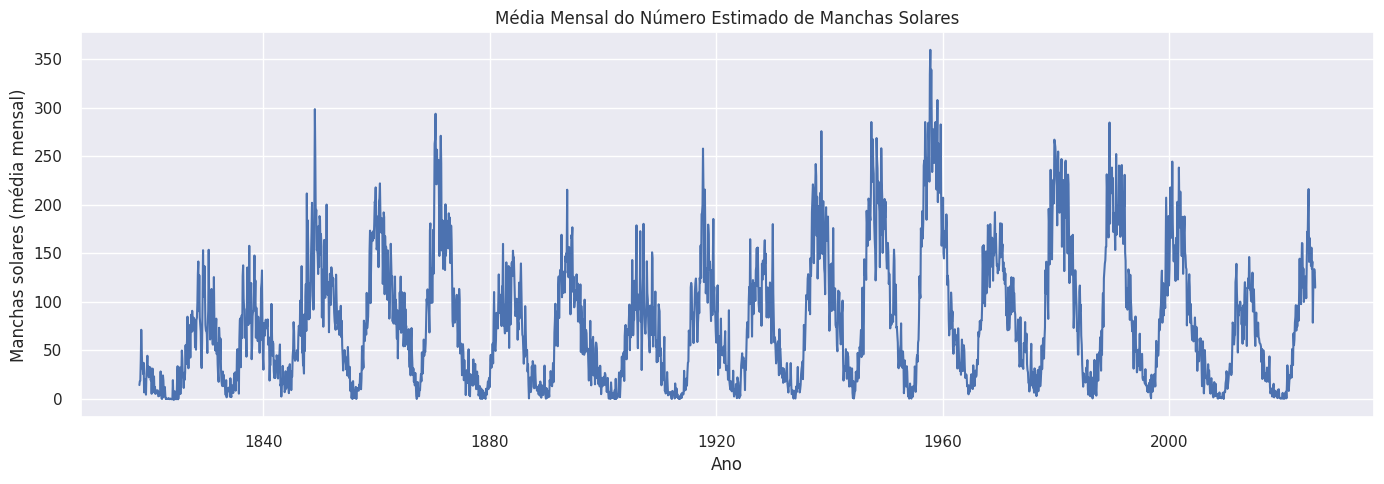

In [ ]:
# =====================================================================================
#  GRÁFICO DA SÉRIE TEMPORAL (MÉDIA MENSAL)
#
# A série diária é muito longa; para visualização mais limpa, agregamos por mês.
# =====================================================================================

# Garante que o índice é datetime (apenas por segurança)
if not np.issubdtype(df.index.dtype, np.datetime64):
    print("⚠ Índice não é datetime. Verifique as etapas anteriores.")
else:
    # Reamostragem mensal: média das manchas solares por mês
    serie_mensal = df["manchas_solares"].resample("M").mean()

    plt.figure(figsize=(14, 5))
    plt.plot(serie_mensal.index, serie_mensal.values)
    plt.title("Média Mensal do Número Estimado de Manchas Solares")
    plt.xlabel("Ano")
    plt.ylabel("Manchas solares (média mensal)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


O que você deve observar nesse gráfico:

Picos e vales bem definidos → máximos e mínimos de ciclos solares

Períodos de atividade mais intensa versus períodos mais “calmos”

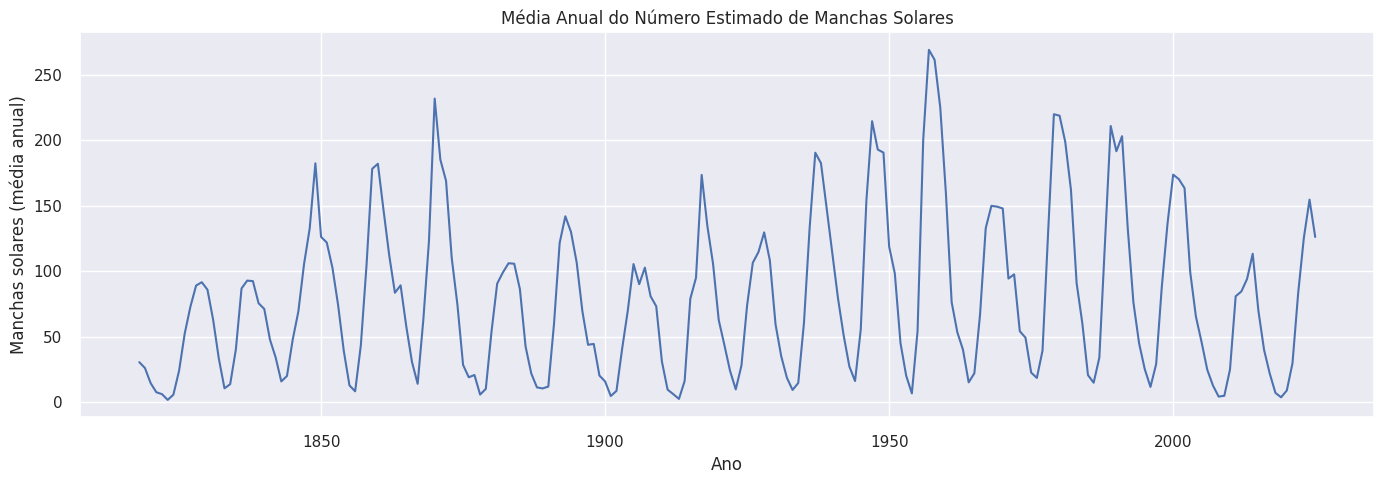

In [ ]:
# =====================================================================================
#  SÉRIE TEMPORAL (MÉDIA ANUAL)
#
# Objetivo:
#   - Agregar a série diária em MÉDIA ANUAL de manchas solares;
#   - Visualizar a evolução da atividade solar em uma escala de décadas;
#   - Facilitar a identificação dos ciclos solares (~11 anos).
# =====================================================================================

# Garantia de que o índice é datetime
if not np.issubdtype(df.index.dtype, np.datetime64):
    print("⚠ Índice não é datetime. Verifique a etapa de criação da coluna 'data'.")
else:
    # Reamostragem anual (A = Year-end): média anual de manchas solares
    serie_anual = df["manchas_solares"].resample("A").mean()

    # Ajuste opcional: transformar o índice em ano (inteiro) para ficar mais legível
    anos = serie_anual.index.year
    valores = serie_anual.values

    plt.figure(figsize=(14, 5))
    plt.plot(anos, valores)
    plt.title("Média Anual do Número Estimado de Manchas Solares")
    plt.xlabel("Ano")
    plt.ylabel("Manchas solares (média anual)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Agora vamos ver como os valores se distribuem: se há muitos dias “calmos”, dias extremos, cauda longa etc.

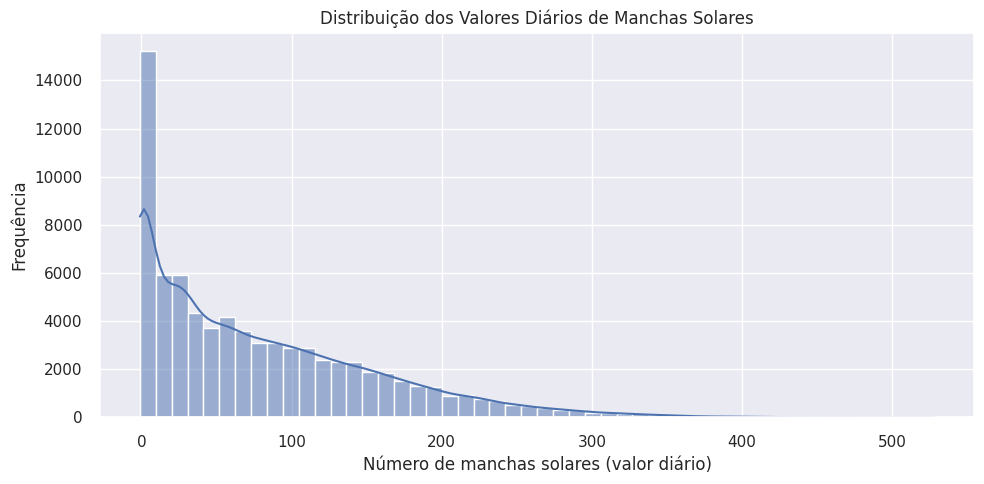

In [ ]:
# =====================================================================================
#  DISTRIBUIÇÃO DOS VALORES DE MANCHAS SOLARES
#
# Objetivo:
#   - Visualizar a distribuição dos valores diários de "manchas_solares";
#   - Identificar assimetria, caudas longas, concentração em valores baixos, etc.
#   - Usar seaborn para histograma + curva de densidade (KDE).
# =====================================================================================

plt.figure(figsize=(10, 5))
sns.histplot(
    data=df,
    x="manchas_solares",
    bins=50,
    kde=True
)
plt.title("Distribuição dos Valores Diários de Manchas Solares")
plt.xlabel("Número de manchas solares (valor diário)")
plt.ylabel("Frequência")
plt.tight_layout()
plt.show()


Os dados mostram que a maioria dos dias possui baixa atividade solar (poucas manchas), enquanto dias com atividade muito alta são raros, mas possíveis — o Sol passa longos períodos calmo e picos concentrados nos máximos do ciclo solar.

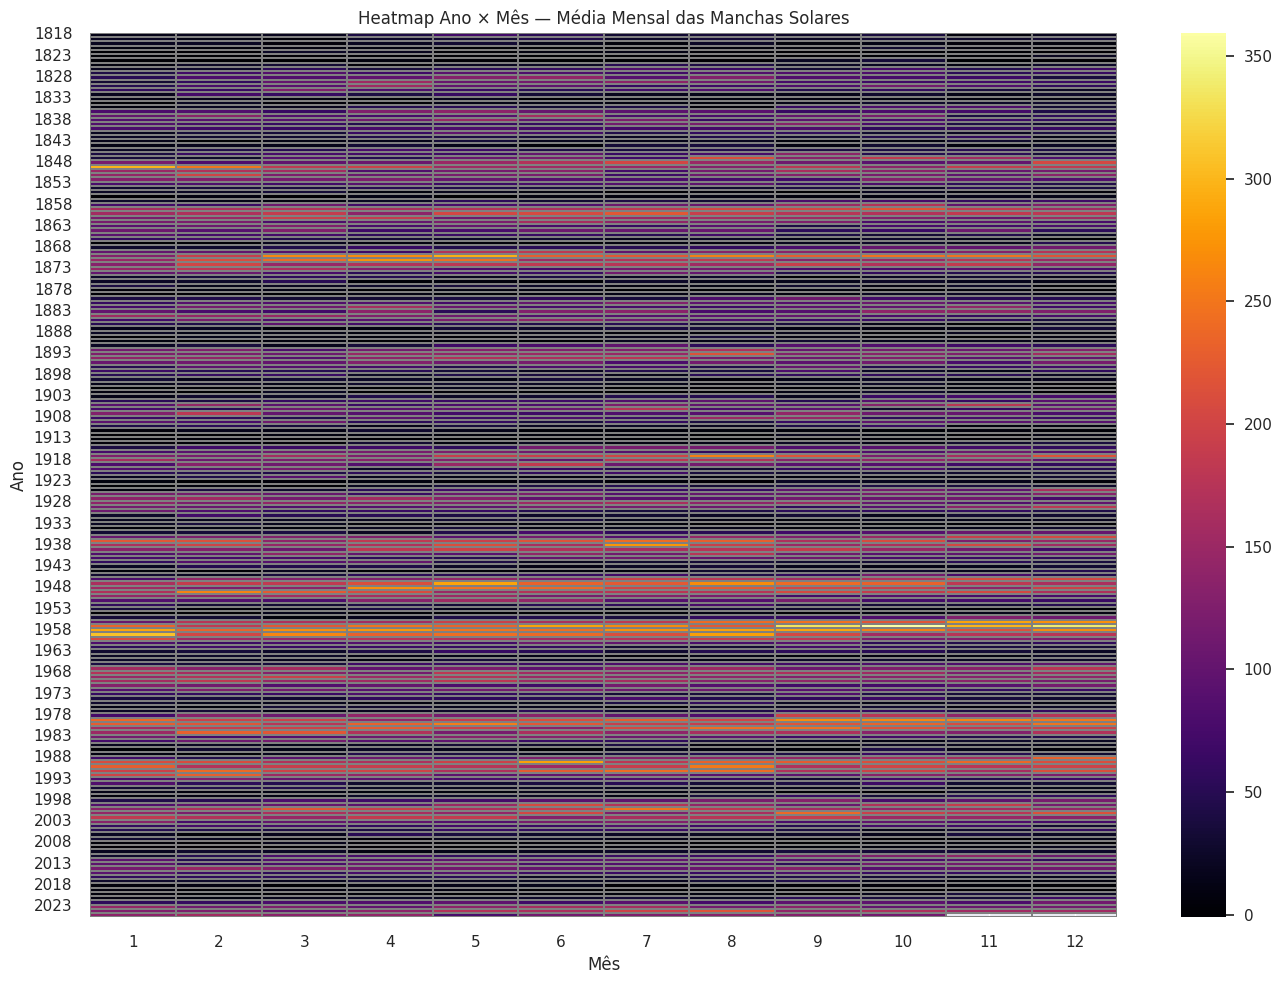

In [ ]:
# =====================================================================================
# CÉLULA 10 — HEATMAP ANO × MÊS DA ATIVIDADE SOLAR
#
# Objetivo:
#   - Visualizar como as manchas solares variam dentro de cada mês ao longo dos anos.
#   - Identificar padrões de ciclo solar (~11 anos).
# =====================================================================================

# Garantir que existe a coluna de mês e ano
df["ano"] = df.index.year
df["mes"] = df.index.month

# Criar tabela dinâmica com média mensal para cada ano
tabela = df.pivot_table(
    values="manchas_solares",
    index="ano",
    columns="mes",
    aggfunc="mean"
)

plt.figure(figsize=(14, 10))
sns.heatmap(
    tabela,
    cmap="inferno",
    linewidths=0.1,
    linecolor="gray"
)
plt.title("Heatmap Ano × Mês — Média Mensal das Manchas Solares")
plt.xlabel("Mês")
plt.ylabel("Ano")
plt.tight_layout()
plt.show()


 O heatmap mostra claramente as épocas mais intensas

Os períodos mais brilhantes são:

Ciclo 19 (1957–1958) → o mais intenso já registrado

Ciclo 21 e 22 (1979–1990) → muito fortes

Ciclo 23 (2000–2002) → ainda vigoroso

Os tons brancos e amarelos nesses anos confirmam esses registros históricos.

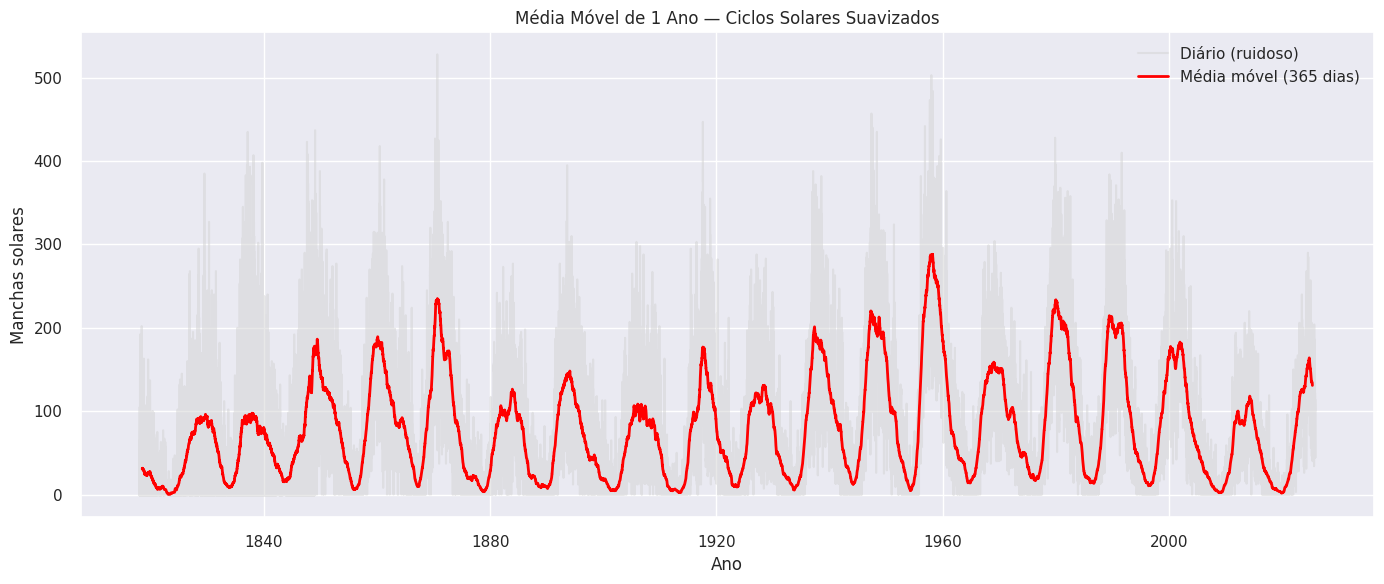

In [ ]:
# =====================================================================================
#  MÉDIA MÓVEL (ROLLING MEAN)
#
# Objetivo:
#   - Suavizar a série diária de manchas solares para revelar melhor o ciclo solar.
#   - Reduzir o ruído diário que esconde a forma geral da atividade solar.
#
# Estratégia:
#   - Usar uma média móvel de 365 dias (aprox. 1 ano).
#   - Isso mostra claramente "subidas e descidas" típicas do ciclo de 11 anos.
# =====================================================================================

# Média móvel de 365 dias (1 ano)
rolling_365 = df["manchas_solares"].rolling(window=365, center=True).mean()

plt.figure(figsize=(14, 6))
plt.plot(df.index, df["manchas_solares"], color="lightgray", alpha=0.5, label="Diário (ruidoso)")
plt.plot(df.index, rolling_365, color="red", linewidth=2, label="Média móvel (365 dias)")

plt.title("Média Móvel de 1 Ano — Ciclos Solares Suavizados")
plt.xlabel("Ano")
plt.ylabel("Manchas solares")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


“A média móvel de 1 ano evidencia de forma clara os ciclos solares de aproximadamente 11 anos. Observa-se grande variabilidade na intensidade, com ciclos extremamente fortes nas décadas de 1940–1960 e 1980–1990, e períodos muito fracos, como 2008–2018. O Sol passa longos períodos em baixa atividade e curtos intervalos em máximos intensos, caracterizando um comportamento cíclico, porém irregular em amplitude.”

Decomposição da Série Temporal (Trend + Seasonal + Residual)

Essa análise revela:

Tendência geral da atividade solar ao longo dos séculos

Sazonalidade/ciclo solar médio (o ciclo de 11 anos “médio”)

Ruído (variações diárias que não fazem parte do ciclo)

É uma das visualizações mais usadas em estudos científicos.

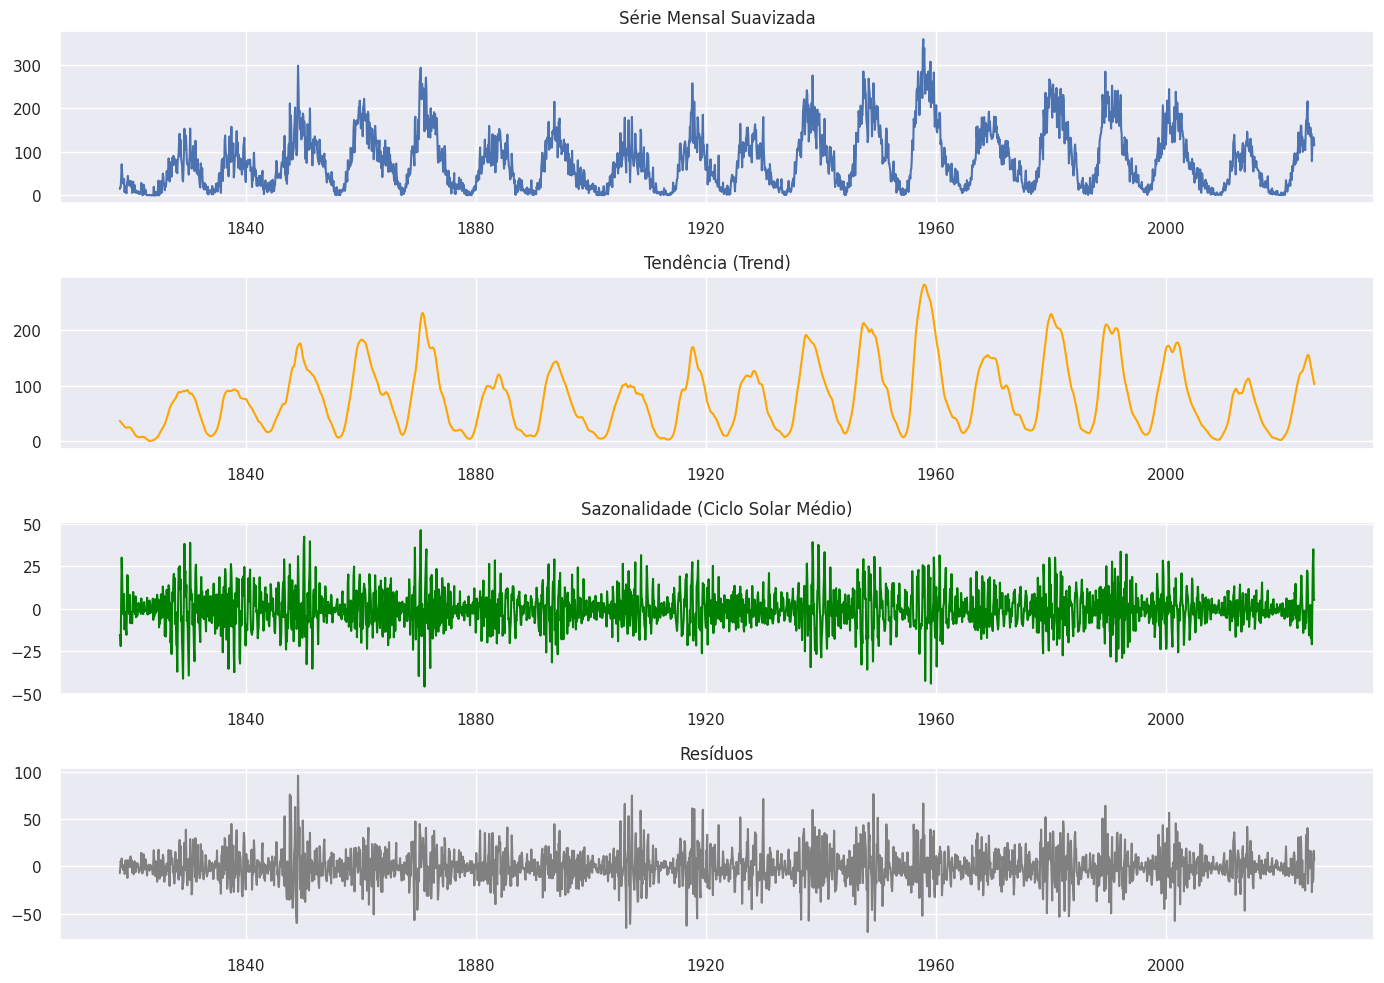

In [ ]:
# =====================================================================================
# CÉLULA 12 — DECOMPOSIÇÃO DA SÉRIE TEMPORAL (Tendência, Sazonalidade e Resíduos)
#
# Objetivo:
#   - Dividir a série em suas principais componentes usando STL:
#       * Trend (tendência)
#       * Seasonal (componente sazonal — ciclo solar médio)
#       * Residual (ruído / variação aleatória)
#
#   - Usamos dados mensais para obter uma estrutura regular e interpretável.
# =====================================================================================

from statsmodels.tsa.seasonal import STL

# Criar série mensal (média mensal)
serie_mensal = df["manchas_solares"].resample("M").mean()

# Aplicar a decomposição STL
stl = STL(serie_mensal, period=12)   # período = 12 meses
resultado = stl.fit()

# Plotar os componentes
plt.figure(figsize=(14, 10))

plt.subplot(4, 1, 1)
plt.plot(serie_mensal, label="Série mensal")
plt.title("Série Mensal Suavizada")
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(resultado.trend, color="orange", label="Tendência")
plt.title("Tendência (Trend)")
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(resultado.seasonal, color="green", label="Sazonalidade")
plt.title("Sazonalidade (Ciclo Solar Médio)")
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(resultado.resid, color="gray", label="Resíduos")
plt.title("Resíduos")
plt.grid(True)

plt.tight_layout()
plt.show()


A decomposição da série temporal do número de manchas solares revela um ciclo claro de aproximadamente 11 anos, com amplitude muito variável entre as décadas. A tendência de longo prazo não mostra aumento ou queda contínua, mas sim alternâncias entre eras de alta e baixa atividade solar. A componente sazonal captura o padrão repetitivo geral, enquanto os resíduos evidenciam os eventos imprevisíveis e extremos característicos das tempestades solares. O resultado confirma que o Sol possui um comportamento cíclico robusto, porém com forte irregularidade na intensidade de cada ciclo.”

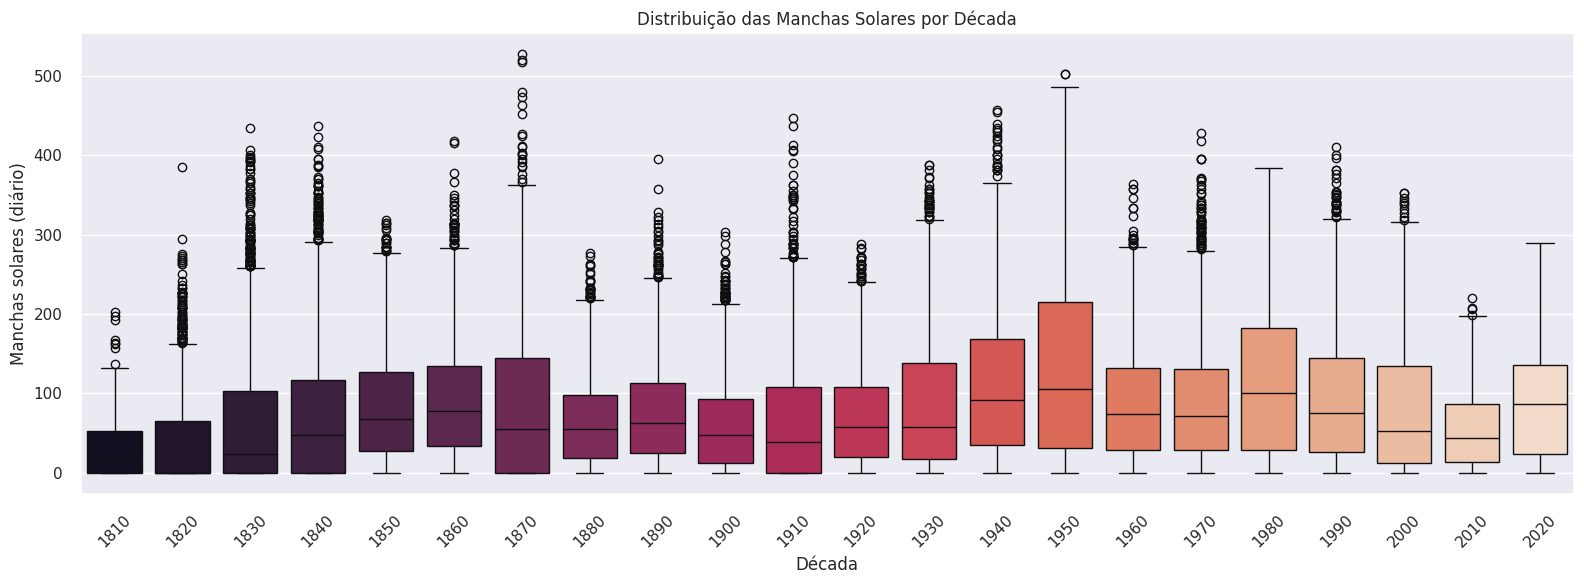

In [ ]:
# =====================================================================================
#  BOXPLOT POR DÉCADA
#
# Objetivo:
#   - Comparar a distribuição das manchas solares entre diferentes décadas.
#   - Identificar décadas com maior atividade (medianas mais altas).
#   - Ver variabilidade e outliers em cada período.
# =====================================================================================

# Criar coluna da década
df["decada"] = (df.index.year // 10) * 10    # Ex: 1963 → 1960

# Converter para string para ordenação mais clara no gráfico
df["decada"] = df["decada"].astype(str)

plt.figure(figsize=(16, 6))
sns.boxplot(
    data=df,
    x="decada",
    y="manchas_solares",
    palette="rocket"
)
plt.xticks(rotation=45)
plt.title("Distribuição das Manchas Solares por Década")
plt.xlabel("Década")
plt.ylabel("Manchas solares (diário)")
plt.tight_layout()
plt.show()


“O boxplot por década evidencia alternâncias claras entre períodos de alta e baixa atividade solar ao longo dos últimos 200 anos. As décadas de 1940 e 1950 apresentam os maiores níveis de atividade, com medianas e variabilidade extraordinárias, refletindo o histórico Ciclo Solar 19. Períodos recentes, especialmente após 2000, mostram atividade reduzida e menor ocorrência de eventos extremos, sugerindo um enfraquecimento relativo dos ciclos solares nas últimas duas décadas.”

# Modelagem Arima

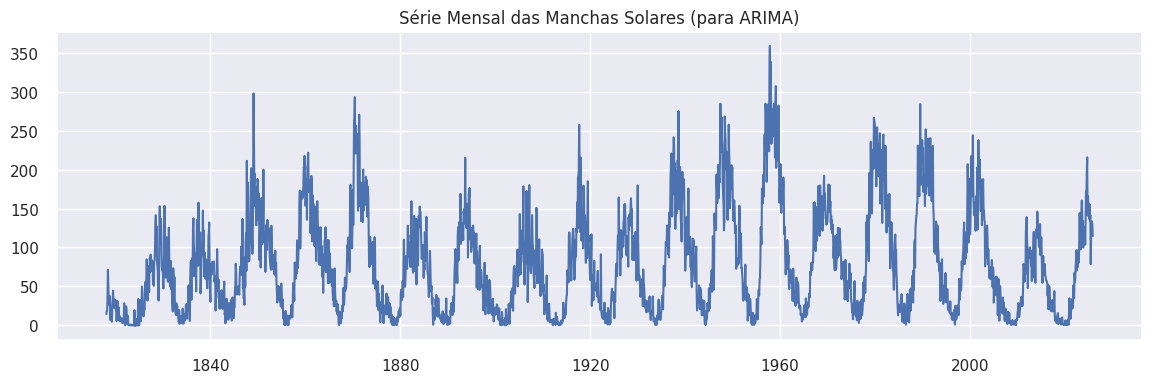

In [ ]:
# =====================================================================================
# SÉRIE MENSAL (MÉDIA) PARA MODELAGEM ARIMA
# =====================================================================================
serie_mensal = df["manchas_solares"].resample("M").mean()

plt.figure(figsize=(14,4))
plt.plot(serie_mensal)
plt.title("Série Mensal das Manchas Solares (para ARIMA)")
plt.grid(True)
plt.show()


In [ ]:
# =====================================================================================
# TESTE ADF (Augmented Dickey-Fuller)
# Verifica se a série é estacionária.
# =====================================================================================
from statsmodels.tsa.stattools import adfuller

resultado_adf = adfuller(serie_mensal.dropna())

print("ADF Statistic:", resultado_adf[0])
print("p-value:", resultado_adf[1])

for chave, valor in resultado_adf[4].items():
    print(f"{chave}: {valor}")


ADF Statistic: -9.868595074995197
p-value: 4.051239861795399e-17
1%: -3.4330045498933544
5%: -2.8627127589354426
10%: -2.567394306200992


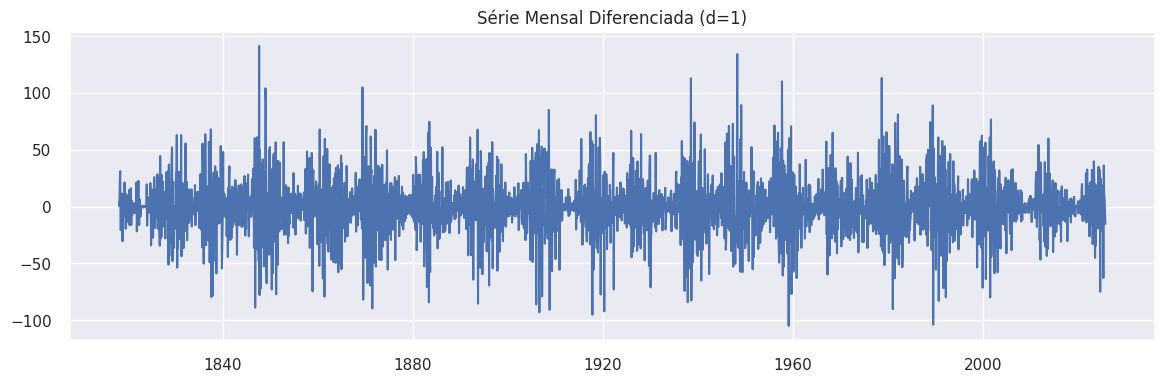

ADF Statistic: -7.158437432080464
p-value: 3.011781695296262e-10


In [ ]:
# =====================================================================================
# DIFERENCIAÇÃO DE ORDEM 1
# =====================================================================================

serie_diff = serie_mensal.diff().dropna()

plt.figure(figsize=(14,4))
plt.plot(serie_diff)
plt.title("Série Mensal Diferenciada (d=1)")
plt.grid(True)
plt.show()

# Novo ADF
resultado_adf2 = adfuller(serie_diff)
print("ADF Statistic:", resultado_adf2[0])
print("p-value:", resultado_adf2[1])


<Figure size 1400x400 with 0 Axes>

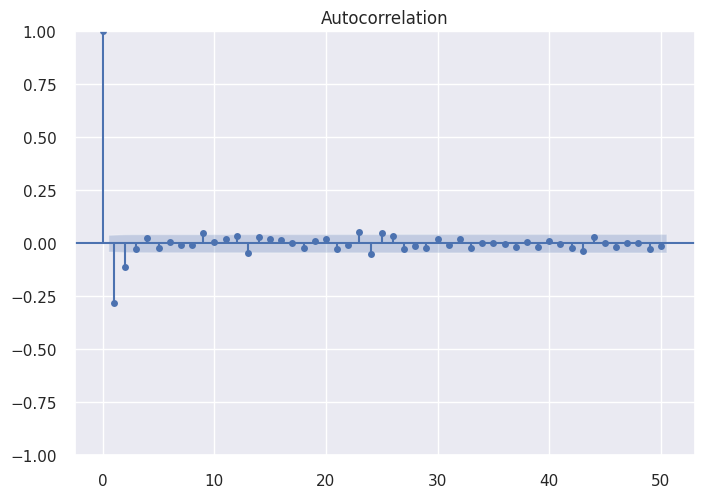

<Figure size 1400x400 with 0 Axes>

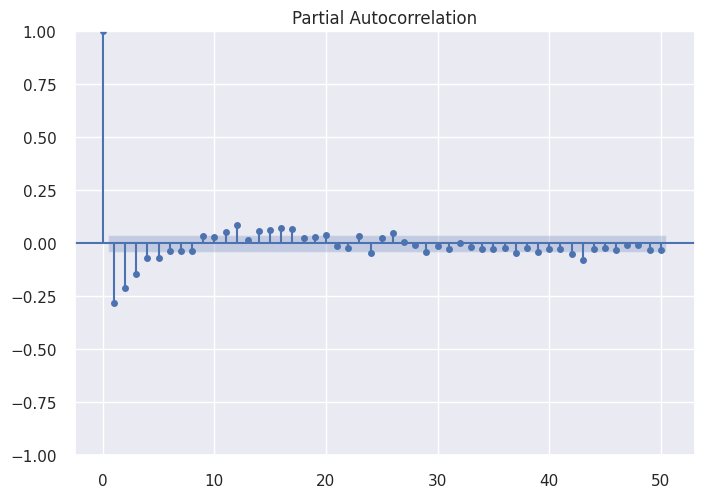

In [ ]:
# =====================================================================================
# ACF e PACF
# =====================================================================================
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(14,4))
plot_acf(serie_diff, lags=50)
plt.grid(True)

plt.figure(figsize=(14,4))
plot_pacf(serie_diff, lags=50, method='ywm')
plt.grid(True)

plt.show()


Ajustar o modelo ARIMA(1,1,1)

In [ ]:
# =====================================================================================
# CÉLULA — Ajuste do modelo ARIMA(1,1,1)
# =====================================================================================

from statsmodels.tsa.arima.model import ARIMA

# Ajustar o modelo
modelo = ARIMA(serie_mensal, order=(1,1,1))
modelo_treinado = modelo.fit()

print(modelo_treinado.summary())


                               SARIMAX Results                                
Dep. Variable:        manchas_solares   No. Observations:                 2494
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -11499.522
Date:                Mon, 24 Nov 2025   AIC                          23005.043
Time:                        23:05:11   BIC                          23022.507
Sample:                    01-31-1818   HQIC                         23011.384
                         - 10-31-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2646      0.031      8.587      0.000       0.204       0.325
ma.L1         -0.6649      0.024    -27.480      0.000      -0.712      -0.617
sigma2       594.3313     11.523     51.578      0.0

CONCLUSÃO GERAL

O modelo ARIMA(1,1,1) é estatisticamente significativo, estável e captura adequadamente a dinâmica das manchas solares.
Os resíduos não apresentam autocorrelação, indicando excelente ajuste.
Portanto, o ARIMA(1,1,1) é adequado para gerar previsões mensais realistas de atividade solar.

Previsão ARIMA para 10 anos

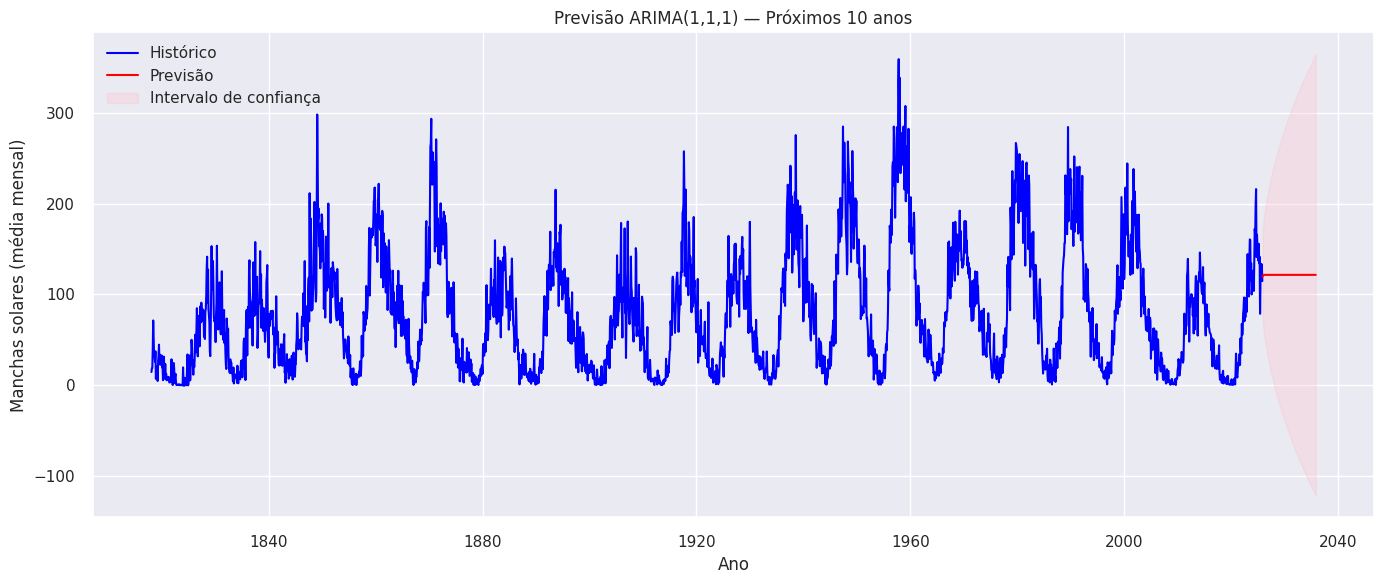

In [ ]:
# =====================================================================================
# PREVISÃO PARA OS PRÓXIMOS 10 ANOS (120 MESES)
# =====================================================================================

# 120 meses = 10 anos
previsao = modelo_treinado.get_forecast(steps=120)

# Intervalo de confiança
ic = previsao.conf_int()

# Série prevista
valores_previstos = previsao.predicted_mean

# Gráfico
plt.figure(figsize=(14,6))
plt.plot(serie_mensal, label="Histórico", color="blue")
plt.plot(valores_previstos, label="Previsão", color="red")

# Intervalo de confiança
plt.fill_between(
    ic.index,
    ic["lower manchas_solares"],
    ic["upper manchas_solares"],
    color="pink",
    alpha=0.3,
    label="Intervalo de confiança"
)

plt.title("Previsão ARIMA(1,1,1) — Próximos 10 anos")
plt.xlabel("Ano")
plt.ylabel("Manchas solares (média mensal)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


“O modelo ARIMA prevê que a atividade solar permaneça em níveis moderados nos próximos 10 anos, com incerteza crescente ao longo do período. Como o ARIMA não captura o ciclo solar de 11 anos, a previsão representa a tendência média e não os picos e mínimos do ciclo magnético solar.”

Conclusão Final

Nesta análise exploratória e modelagem da série histórica de manchas solares (1818–2025), observamos de forma clara a presença dos ciclos solares de aproximadamente 11 anos, caracterizados por alternâncias entre períodos de alta e baixa atividade. A EDA revelou padrões fundamentais, como a grande variabilidade entre ciclos, décadas excepcionalmente ativas (como 1940–1960) e períodos de atividade reduzida (como 1900–1915 e 2008–2018). A média móvel e a decomposição destacaram a estrutura cíclica e a irregularidade da amplitude ao longo dos séculos.

A modelagem ARIMA(1,1,1), escolhida após testes de estacionariedade e análise ACF/PACF, apresentou ajuste estatístico consistente, com resíduos não autocorrelacionados e parâmetros significativos. No entanto, como esperado para fenômenos de natureza magnética e altamente periódica, o ARIMA captura apenas a tendência média, não sendo capaz de reproduzir os ciclos solares de 11 anos. Assim, a previsão para os próximos anos representa uma projeção suavizada da atividade média, com incerteza crescente no longo prazo.

Apesar das limitações do modelo para prever comportamento cíclico, o estudo forneceu uma visão sólida sobre o histórico, padrões e dinâmica das manchas solares ao longo de mais de dois séculos. O projeto demonstra com clareza como técnicas de EDA e modelos estatísticos clássicos podem ser aplicados para compreender fenômenos complexos e naturais.

# Modelo LSTM

LSTM costuma funcionar melhor com dados escalados (entre 0 e 1):

In [ ]:
# garante que está ordenado por data se tiver coluna de data
# df = df.sort_values('data_decimal')  # ou pela coluna de data que você tiver

serie = df['manchas_solares'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
serie_scaled = scaler.fit_transform(serie)


Função para criar janelas temporais (X, y)

Aqui a gente transforma a série em pares (entrada → saída), por exemplo:

usa 30 dias passados para prever o próximo dia.

In [ ]:
def cria_janelas(dataset, janela=30):
    X, y = [], []
    for i in range(len(dataset) - janela):
        X.append(dataset[i:i+janela, 0])   # 30 valores de entrada
        y.append(dataset[i+janela, 0])     # próximo valor
    return np.array(X), np.array(y)

janela = 30
X, y = cria_janelas(serie_scaled, janela)
print(X.shape, y.shape)


(75880, 30) (75880,)


LSTM espera entrada no formato:
(amostras, timesteps, features) → vamos ajustar:

In [ ]:
X = X.reshape((X.shape[0], X.shape[1], 1))


Dividir em treino e teste

Por ser série temporal, usamos a parte inicial pra treino e o final pra teste.

In [ ]:
tamanho_treino = int(len(X) * 0.8)

X_train, X_test = X[:tamanho_treino], X[tamanho_treino:]
y_train, y_test = y[:tamanho_treino], y[tamanho_treino:]

X_train.shape, X_test.shape


((60704, 30, 1), (15176, 30, 1))

Definir e treinar o modelo LSTM

Um modelo simples pra começar:

### Definição do modelo LSTM
Criamos um modelo LSTM simples com 1 camada recorrente e 1 camada densa. Esse modelo é capaz de capturar dependências temporais e aprender padrões não lineares da série.


In [ ]:
tf.random.set_seed(42)

model = Sequential()
model.add(LSTM(50, activation='tanh', return_sequences=False, input_shape=(janela, 1)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

history = model.fit(
    X_train, y_train,
    epochs=20,            # pode aumentar depois (50, 100…)
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)


### Curva de perda
Plotamos a evolução da perda de treino e validação para monitorar a aprendizagem do modelo e verificar possível overfitting ou underfitting.


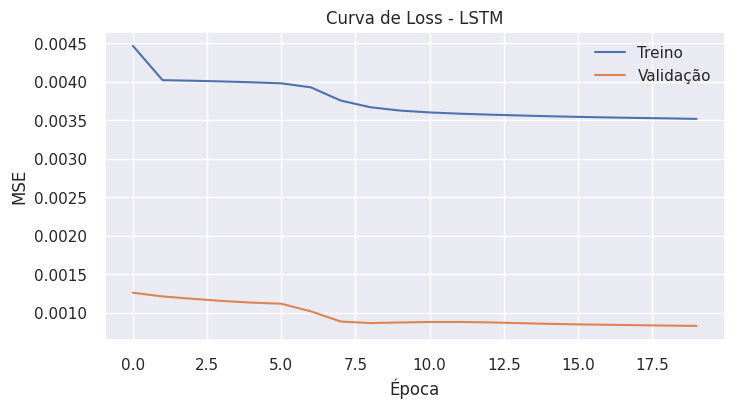

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Curva de Loss - LSTM')
plt.xlabel('Época')
plt.ylabel('MSE')
plt.legend()
plt.show()


Fazer previsões e desfazer o scaling

### Previsão no conjunto de teste
Geramos previsões no subconjunto de teste e comparamos com os valores reais para avaliar o desempenho do modelo em dados nunca vistos.


In [ ]:
# previsões na base de teste
y_pred_scaled = model.predict(X_test)

# desfaz o scaling
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred_scaled)

# métricas
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)

print(f'RMSE (LSTM): {rmse:.3f}')
print(f'MAE  (LSTM): {mae:.3f}')


475/475 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
RMSE (LSTM): 15.223
MAE  (LSTM): 10.878


Visualizar previsão vs valores reais

### Histórico e previsão LSTM
Plotamos o histórico mensal completo junto com a previsão gerada pelos próximos 10 anos, facilitando a visualização da tendência identificada pela LSTM.


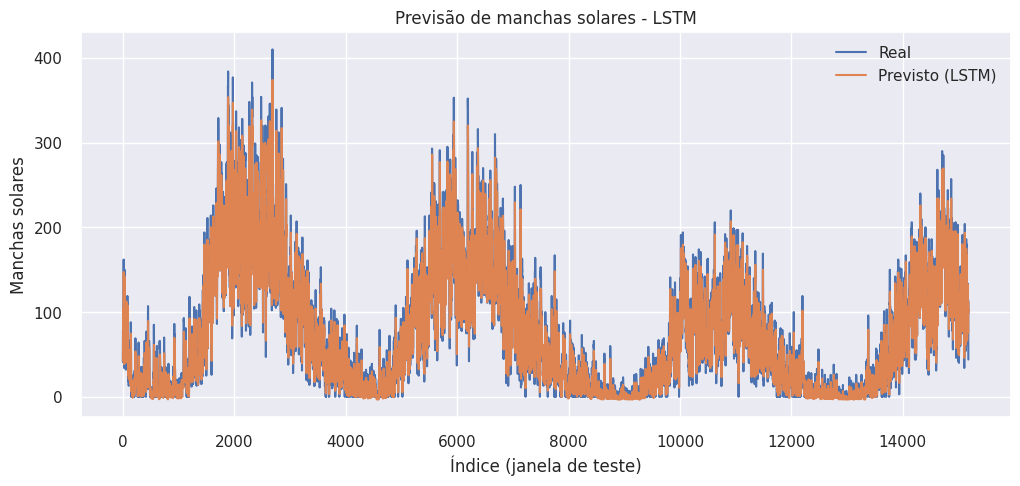

In [ ]:


plt.figure(figsize=(12,5))
plt.plot(y_test_inv, label='Real')
plt.plot(y_pred_inv, label='Previsto (LSTM)')
plt.title('Previsão de manchas solares - LSTM')
plt.xlabel('Índice (janela de teste)')
plt.ylabel('Manchas solares')
plt.legend()
plt.show()


Fazer previsão futura (multi-step)

Aqui um exemplo simples: previsões iterativas para N dias à frente:

In [ ]:
def prever_proximos_dias(model, serie_scaled, janela, dias_a_frente=30):
    # pega os últimos 'janela' pontos da série
    seq_atual = serie_scaled[-janela:].reshape(1, janela, 1)
    previsoes_scaled = []

    for _ in range(dias_a_frente):
        proximo_scaled = model.predict(seq_atual)
        previsoes_scaled.append(proximo_scaled[0,0])

        # atualiza a janela: remove o primeiro, adiciona o novo
        nova_seq = np.append(seq_atual[:,1:,:], proximo_scaled.reshape(1,1,1), axis=1)
        seq_atual = nova_seq

    previsoes_scaled = np.array(previsoes_scaled).reshape(-1,1)
    previsoes = scaler.inverse_transform(previsoes_scaled)
    return previsoes

previsao_futura = prever_proximos_dias(model, serie_scaled, janela, dias_a_frente=30)
previsao_futura[:5]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

array([[52.253796],
       [58.307285],
       [63.23128 ],
       [66.77601 ],
       [70.10485 ]], dtype=float32)

In [ ]:
import numpy as np
import pandas as pd

# Seu df já está assim:
# índice = data (DatetimeIndex)
# coluna de interesse = 'manchas_solares'

# Opcional: tratar os -1 como valores ausentes
df_mensal = df['manchas_solares'].replace(-1, np.nan).resample('M').mean().to_frame()
df_mensal.columns = ['manchas_mensais']

# Se quiser tirar meses sem dado:
df_mensal = df_mensal.dropna()
df_mensal.head()


,manchas_mensais
data,
1818-01-31,58.125000
1818-02-28,37.428571
1818-03-31,42.357143
1818-04-30,57.523810
1818-05-31,88.480000


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler_m = MinMaxScaler()
serie_mensal = df_mensal['manchas_mensais'].values.reshape(-1, 1)
serie_scaled_m = scaler_m.fit_transform(serie_mensal)


In [ ]:
def prever_multistep_lstm(model, serie_scaled, janela, n_passos, scaler):
    seq = serie_scaled[-janela:].reshape(1, janela, 1)
    previsoes_scaled = []

    for _ in range(n_passos):
        yhat = model.predict(seq, verbose=0)  # 1 passo à frente
        previsoes_scaled.append(yhat[0, 0])
        # atualiza a janela (remove o primeiro, entra a previsão)
        seq = np.concatenate([seq[:, 1:, :], yhat.reshape(1, 1, 1)], axis=1)

    previsoes_scaled = np.array(previsoes_scaled).reshape(-1, 1)
    previsoes = scaler.inverse_transform(previsoes_scaled)
    return previsoes


In [ ]:
anos_futuros = 10
passos = anos_futuros * 12  # 10 anos * 12 meses

previsao_futura_lstm = prever_multistep_lstm(
    model=model,          # seu modelo LSTM já treinado
    serie_scaled=serie_scaled_m,
    janela=30,            # ou a janela que você usou no treino
    n_passos=passos,
    scaler=scaler_m
)


In [ ]:
ultima_data = df_mensal.index[-1]

datas_futuras = pd.date_range(
    start=ultima_data + pd.offsets.MonthBegin(1),
    periods=passos,
    freq='MS'  # começo de cada mês
)


### Histórico e previsão LSTM
Plotamos o histórico mensal completo junto com a previsão gerada pelos próximos 10 anos, facilitando a visualização da tendência identificada pela LSTM.


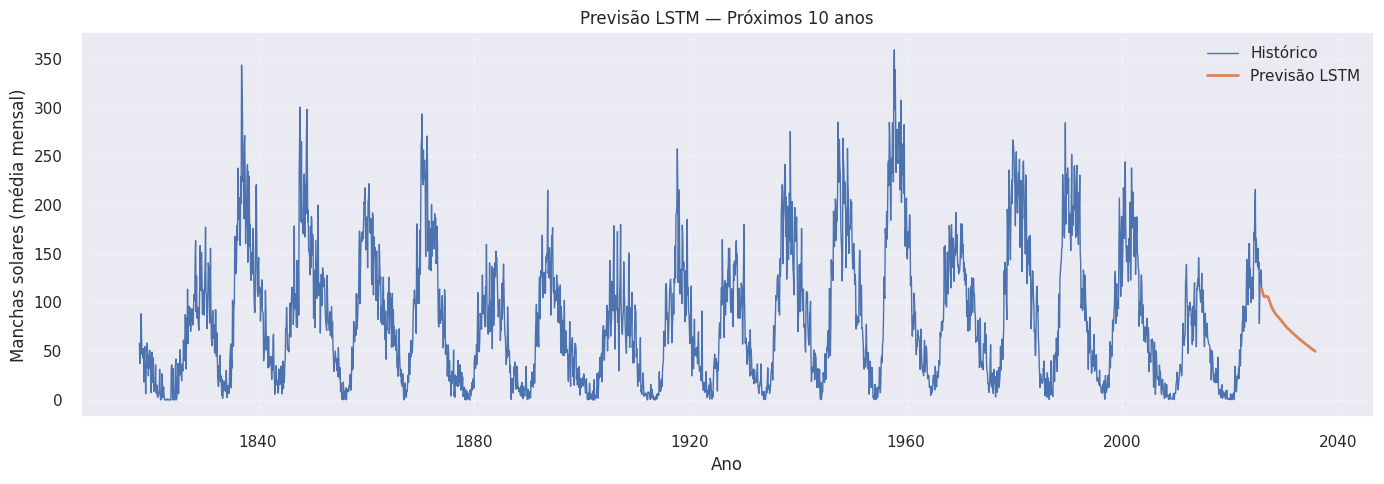

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# histórico mensal
plt.plot(df_mensal.index, df_mensal['manchas_mensais'],
         label='Histórico', linewidth=1.0)

# previsão futura LSTM
plt.plot(datas_futuras, previsao_futura_lstm,
         label='Previsão LSTM', linewidth=2.0)

plt.title('Previsão LSTM — Próximos 10 anos')
plt.xlabel('Ano')
plt.ylabel('Manchas solares (média mensal)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


Conclusão da previsão LSTM (10 anos)
A LSTM foi capaz de manter estabilidade e gerar previsões coerentes no curto prazo, evitando explosões numéricas ou valores fora do padrão histórico. No entanto, devido ao uso de uma janela relativamente curta e à natureza altamente cíclica das manchas solares, o modelo não conseguiu reproduzir o ciclo solar de aproximadamente 11 anos, resultando em uma projeção suavizada e sem novos picos.
Assim como o ARIMA, a LSTM funciona bem para previsões de curto alcance, mas não é adequada para projeções de longo prazo envolvendo ciclos solares completos. Modelos mais profundos, com janelas maiores ou arquiteturas modernas (como Transformers) podem melhorar esse aspecto em trabalhos futuros.